# Introduction:

The dataset for further analysis is customer service log from a certain company.

# The questions about this dataset:

1. How many channels are typically required for a single call? 

2. Can you provide a range for the duration of calls? 

3. Are there specific trends describing whether calls are solved? 

4. Which channels should we prioritize for improvement? 

5. How should we measure the success of future improvement?

In [1]:
# Import the required library
import pandas as pd
import matplotlib.pyplot as plt

## Load the data:

In [2]:
# Load the csv file and convert it to be a pandas dataframe and print out the head
df = pd.read_csv("call_logging.csv")
df.head()

,time,is_solved,userId,channelName
0,1.556374e+09,0,26643,channel_0
1,1.546934e+09,0,636656,channel_1
2,1.544429e+09,0,485014,channel_2
3,1.547461e+09,0,772798,channel_1
4,1.546843e+09,0,877701,channel_3


## Asess the data:

In [3]:
# Check the rows and columns of this dataset
df.shape  

(14772712, 4)

In [4]:
# Check datatypes 
df.dtypes

time           float64
is_solved        int64
userId           int64
channelName     object
dtype: object

In [5]:
# Check each columns number of unique values 
df.nunique()

time           7929452
is_solved            2
userId         1000976
channelName         23
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14772712 entries, 0 to 14772711
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   time         float64
 1   is_solved    int64  
 2   userId       int64  
 3   channelName  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 450.8+ MB


In [7]:
# Check null values in each column
df.isnull().sum()

time           146601
is_solved           0
userId              0
channelName    219224
dtype: int64

## Clean the data:

In [8]:
# Drop all rows with all NaN and NaT values in "channelName" AND "time" columns
df.dropna(inplace=True)

In [9]:
# Confirm the deletion
df.isnull().sum()

time           0
is_solved      0
userId         0
channelName    0
dtype: int64

In [10]:
# Check if there are some duplicates
df.duplicated().sum()

86

In [11]:
# Drop the duplicates
df.drop_duplicates(inplace=True)

In [12]:
# Confirm the deletion of duplicates
df.duplicated().sum()

0

In [13]:
# Convert the UNIX time format to pandas datetime
df["time"] = pd.to_datetime(df["time"], unit="s")

### Q1: How many channels are typically required for a single call?

In [14]:
# Count the channels used for each customer
# Deactivate multiindexing for easier use
channels_used = df.groupby(["userId"], as_index=False)["channelName"].value_counts()
channels_used

,userId,channelName,count
0,1,channel_5,4
1,1,channel_3,2
2,1,channel_0,1
3,1,channel_4,1
4,1,channel_2,1
...,...,...,...
6990849,10001000,channel_2,23
6990850,10001000,channel_15,19
6990851,10001000,channel_18,13
6990852,10001000,channel_21,9


In [15]:
channels_used_only_once = channels_used.loc[channels_used["count"] == 1].drop(columns="channelName")

In [16]:
counts_of_channels_used_only_once_from_each_user = channels_used_only_once.groupby("userId", as_index=False)["count"].sum()

**Answer:**

In [17]:
f"{int(counts_of_channels_used_only_once_from_each_user['count'].mean().round())} channels"

'4 channels'

The typical channels required for a single call are 4 channels.

### Q2: Can you provide a range for the duration of calls?

In [18]:
# Sort the data by time
df.sort_values(by="time", inplace=True)

In [19]:
# Get the time interval between two subsequent calls
df["time_interval"] = df["time"].diff().fillna(pd.Timedelta(0)).apply(lambda x: x.total_seconds())

**Answer:**

In [20]:
# Calculate the range of duration of calls by subtracting the maximum with the minimum value 
range_of_duration_of_calls = int(df["time_interval"].max() - df["time_interval"].min())
f"{range_of_duration_of_calls} seconds"

'78 seconds'

The range for the duration of the calls is 78 seconds.

### Q3: Are there specific trends describing whether calls are solved?

In [21]:
# Drop the time_interval column
df.drop(columns="time_interval", inplace=True)

 Count, for each hour, the number of calls that were received from all of the recorded data. 

In [22]:
# Group by the hours of calls received and count how many calls that were received
hour_grp_is_solved = df.groupby([df["time"].dt.hour], as_index=False)["is_solved"].value_counts()

 Count the calls that were received from all of the recorded data on each day. 

In [33]:
# Group by the days of calls received and count how many calls that were solved or not
day_grp_is_solved = df.groupby([df["time"].dt.day_name()], as_index=False)["is_solved"].value_counts()

# Sort the data by the day name of a week
sort = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_grp_is_solved["time"] = pd.Categorical(day_grp_is_solved["time"], categories=sort, ordered=True)
day_grp_is_solved = day_grp_is_solved.sort_values("time")

# Rename "time" column to "day_name"
day_grp_is_solved.rename(columns={"time": "day_name"}, inplace=True)

**Answer:**

The trend based on the hours of calls that were solved is skewed to the left. Which means the majority of the calls that were resolved, as hours goes by, were decreased.

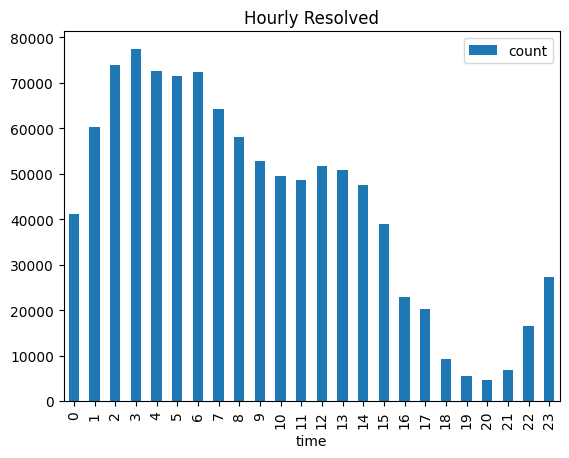

In [23]:
# Visualize the calls that were solved by each hour
hour_grp_is_solved.loc[hour_grp_is_solved["is_solved"] == 1].plot(x="time", y="count", title="Hourly Resolved", kind="bar")
plt.show()

For most of the days, the number of calls that were solved were decreased.

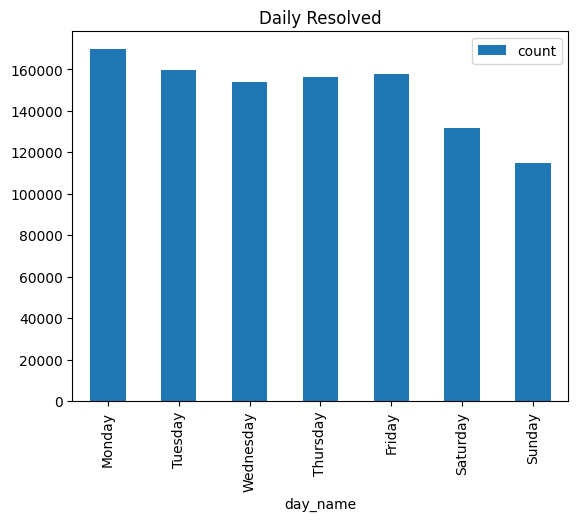

In [25]:
day_grp_is_solved.loc[day_grp_is_solved["is_solved"] == 1].plot(x="day_name", y="count", title="Daily Resolved", kind="bar")
plt.show()

### Q4: Which channels should we prioritize for improvement? 

 Count the number of calls that were received from all of the recorded data for each channel. 

In [26]:
# Group by channels that received the calls and count how many calls that were solved or not 
channel_grp_is_solved = df.groupby("channelName", as_index=False)["is_solved"].value_counts()

# Extract the digits in channel's name and convert it to integer and make new column out of it
channel_grp_is_solved["sort"] = channel_grp_is_solved["channelName"].str.extract("(\d+)").astype(int)

# Sort the dataframe by the values of "sort"
channel_grp_is_solved.sort_values("sort", inplace=True)

# Delete the "sort" column
channel_grp_is_solved = channel_grp_is_solved.drop("sort", axis=1)

For each channel, count the number of calls that were received **whether or not they are solved**.

In [27]:
# Group by channels that received the calls and sum how many times it received the calls
channels_received_calls_count = channel_grp_is_solved.groupby("channelName").sum().reset_index()

# Extract the digits in channel's name and convert it to integer and make new column out of it
channels_received_calls_count["sort"] = channels_received_calls_count["channelName"].str.extract("(\d+)").astype(int)

# Sort the dataframe by the values of "sort"
channels_received_calls_count.sort_values("sort", inplace=True)

# Delete certain columns
channels_received_calls_count = channels_received_calls_count.drop(["sort", "is_solved"], axis=1)

How many calls that were **received** by each channel?

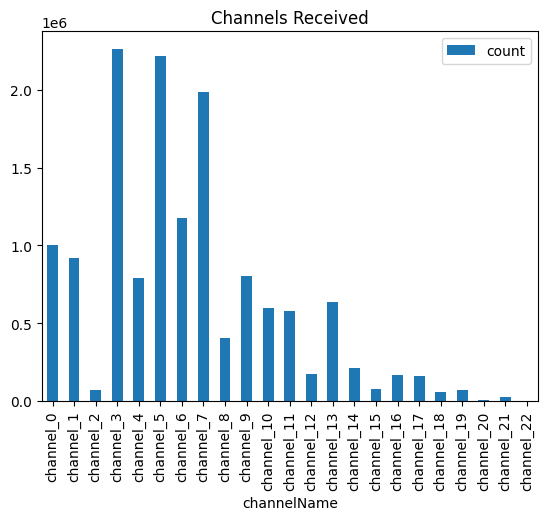

In [28]:
channels_received_calls_count.plot(x="channelName", y="count", title="Channels Received", kind="bar")
plt.show()

How many calls that were **solved** by each channel?

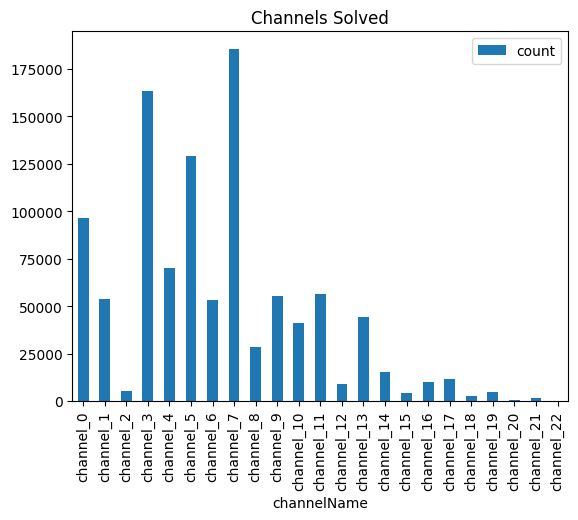

In [29]:
channel_grp_is_solved.loc[channel_grp_is_solved["is_solved"] == 1].plot(x="channelName", y="count", title="Channels Solved", kind="bar")
plt.show()

How many calls that were **not solved** by each channel?

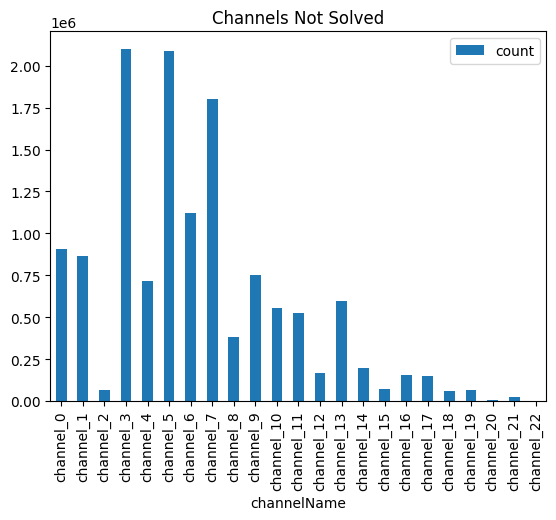

In [30]:
channel_grp_is_solved.loc[channel_grp_is_solved["is_solved"] == 0].plot(x="channelName", y="count", title="Channels Not Solved", kind="bar")
plt.show()

**Answer:**

Channels that we should prioritize for improvement based on above charts are:
1. channel_3. Because it is the channel that used the most by customers and it is also the channel that was not solved customer's needs the most.
2. channel_7. Because it is one of the channels that is frequently used by customers and the channel that, at most, solved customers' needs. 

### Q5: How should we measure the success of future improvement?

The metric I use to measure the success of future improvement is based on customer satisfaction ("is_solved" column).

In [31]:
# Group by years and months that received calls
year_grp_is_solved = df.groupby([df["time"].dt.year], as_index=False)["is_solved"].value_counts()
month_grp_is_solved = df.groupby([df["time"].dt.to_period('M')], as_index=False)["is_solved"].value_counts()

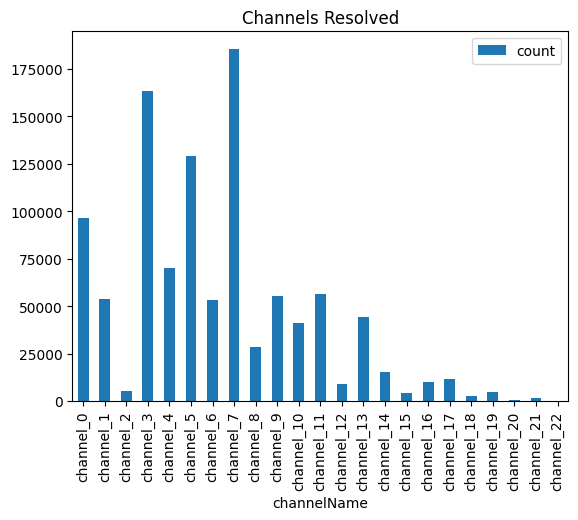

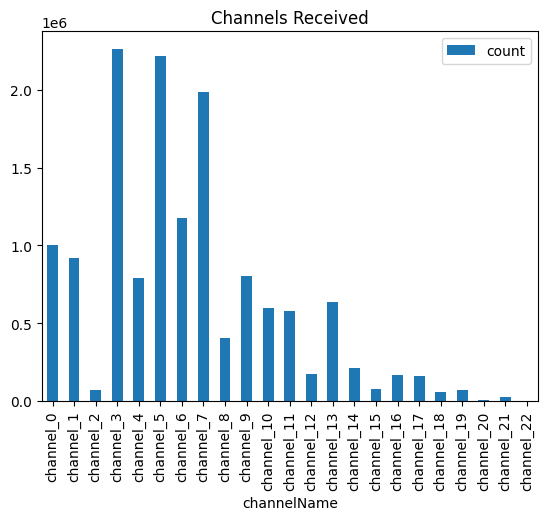

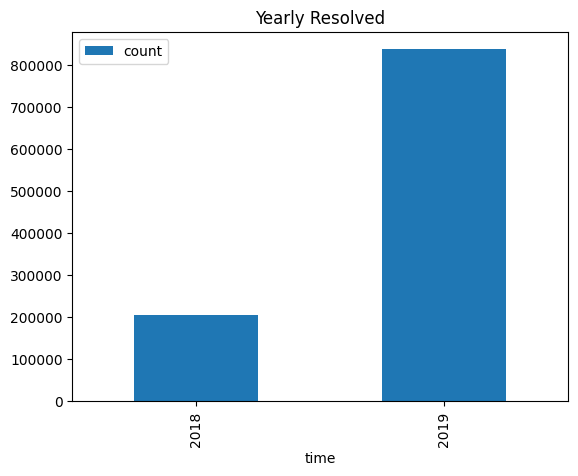

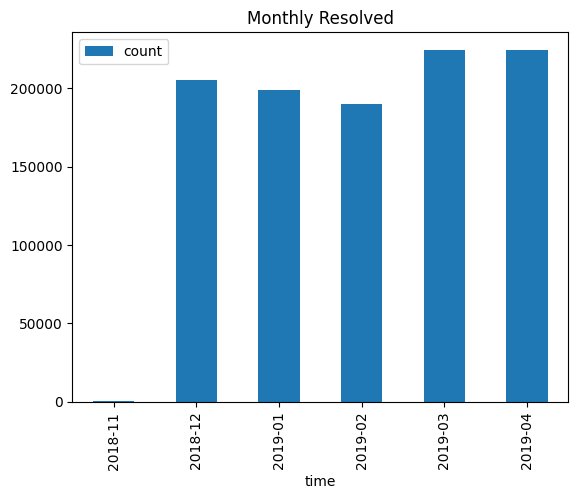

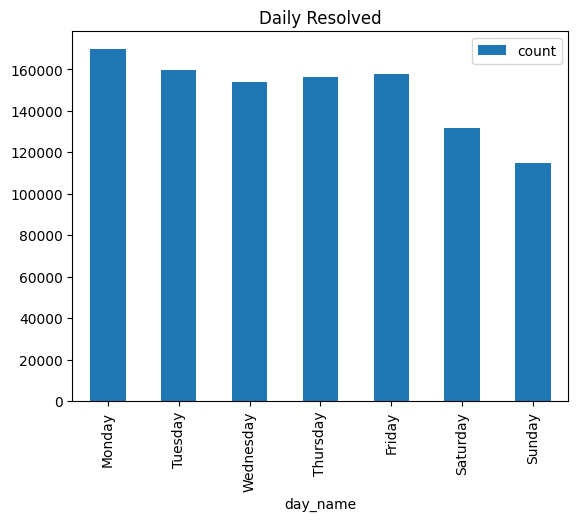

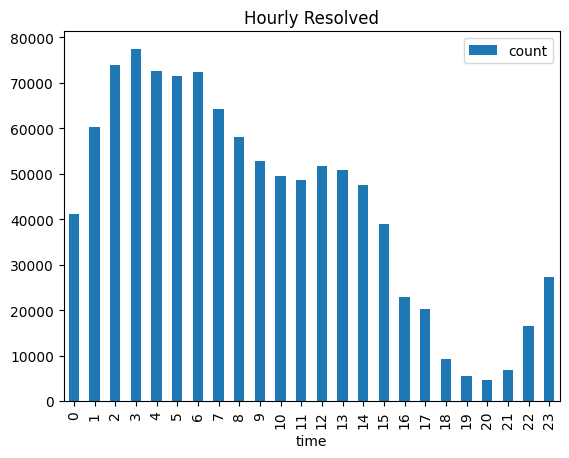

In [32]:
channel_grp_is_solved.loc[channel_grp_is_solved["is_solved"] == 1].plot(x="channelName", y="count", title="Channels Resolved", kind="bar")
channels_received_calls_count.plot(x="channelName", y="count", title="Channels Received", kind="bar")
year_grp_is_solved.loc[year_grp_is_solved["is_solved"] == 1].plot(x="time", y="count", title="Yearly Resolved", kind="bar")
month_grp_is_solved.loc[month_grp_is_solved["is_solved"] == 1].plot(x="time", y="count", title="Monthly Resolved", kind="bar")
day_grp_is_solved.loc[day_grp_is_solved["is_solved"] == 1].plot(x="day_name", y="count", title="Daily Resolved", kind="bar")
hour_grp_is_solved.loc[hour_grp_is_solved["is_solved"] == 1].plot(x="time", y="count", title="Hourly Resolved", kind="bar")
plt.show()

**Answer:**

As charts above show, the objective is to **maintain and improve**, if possible, the **quality of the channels that performed well** (resolved many of the customers' needs and received the most calls) and the **time (daily and hourly) that solved the most calls**. Thus the metric to measure the success of future improvement is if the **quality of those channels**, and the **times that resolved the most calls** are improving from time to time.

## Report:

1. How many channels are typically required for a single call? 

2. Can you provide a range for the duration of calls? 

3. Are there specific trends describing whether calls are solved? 

4. Which channels should we prioritize for improvement? 

5. How should we measure the success of future improvement?